Perform - and explain steps of - data cleaning, feature engineering
  (end of game score, score std, home vs away, opponent score vs. 
  opponent average, etc), correlation values, and generate some 
  visualizations to show my EDA approach. There are almost limitless
  possibilities to the data that we could use and engineer, so we will
  start out with a fairly basic model where we don't do quarterly or
  player- and play-specific analysis. We can add in more granular details
  after we evaluate the initial model.

In this specific case, build 2 models: 1 using whole season statistics,
  another using some number of prior games only. Split the data into
  train, validation, and test portions (I'm assuming it won't be sparse).
  Display confusion matrices along with model statistics (accuracy, 
  recall, etc.). Compare the results to see if there is an appreciable
  difference between results - bonus points for bringing in even more
  data to test the models on?

Next steps: include individual player statistics, injury flags, quarterly
  statistics, and more.

In order to meet their level of understanding, regular comments between
  each chunk - what's the purpose behind what I'm about to do - and
  discussion of the results afterwards.

## Hypothesis

Team metrics in the 10 games prior to a tournament are stronger predictors of success than full season metrics. The best predictors will use both full-season and partial-season metrics.


## The test

Build 3 models with the same base data. One will have feature engineering based on running statistical calculations, the second will use full season statistics, and the third will utilize both. Compare model results for multiple NCAA tourneys between the three models.

## Let's begin coding, shall we?
Start with importing the libraries we'll be using in this notebook.

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Load and examine the data

For our data we are going to use the files provided for the March Madness 2022 Kaggle competition. In a future version I plan to build a web scraper that will collect the appropriate data.

Let's pull in the data and display it, allowing us to take a quick glimpse at it's composition, dimensions, and labels. Then we'll look at the data types and null counts.

In [2]:
raw_data = pd.read_csv('C:/Users/soter/Programming Projects/Data Science Projects/NCAA_predictor/NCAA_stats/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
raw_data

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11


Let's take a look at our column names, then we'll discuss them and thoughts on how to use them.

In [3]:
raw_data.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

DayNum: Day of the season that the game was played. Might have some significance - injuries, wear and tear, going on a run - but I think the effect will show up in the other statistics measured. We'll drop this column.

WTeamID, WScore, LTeamID, LScore: The most important numbers - who won and what the score was! The scores will, as mentioned previously, be used to calculate aggregate averages and standard deviations for one model, and running averages and standard deviations for the other.

WLoc: Home or Away value, indicating which team won. Definitely keeping, we'll change it into a binary value.

NumOT: An interesting bit of information; games that take longer than the standard amount of time could have an greater effect on averages, most likely an artificial inflation. We will have to decide if we're going to take a fractional amount of the total based off the number of overtimes, or if we're going to look at the more detailed box scores in order to have exact values. I think that we'll start off with the simpler model, then afterwards compare it with a model utilizing the box scores.

WFGM - LPF: A slew of metrics - field goals made, attempted, offensive and defensive rebounds, and others - for both the winning and losing team. We will use these values in the same was as the scores for each team.


## How clean is the data?

In [4]:
raw_data.info(), raw_data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100423 entries, 0 to 100422
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   100423 non-null  int64 
 1   DayNum   100423 non-null  int64 
 2   WTeamID  100423 non-null  int64 
 3   WScore   100423 non-null  int64 
 4   LTeamID  100423 non-null  int64 
 5   LScore   100423 non-null  int64 
 6   WLoc     100423 non-null  object
 7   NumOT    100423 non-null  int64 
 8   WFGM     100423 non-null  int64 
 9   WFGA     100423 non-null  int64 
 10  WFGM3    100423 non-null  int64 
 11  WFGA3    100423 non-null  int64 
 12  WFTM     100423 non-null  int64 
 13  WFTA     100423 non-null  int64 
 14  WOR      100423 non-null  int64 
 15  WDR      100423 non-null  int64 
 16  WAst     100423 non-null  int64 
 17  WTO      100423 non-null  int64 
 18  WStl     100423 non-null  int64 
 19  WBlk     100423 non-null  int64 
 20  WPF      100423 non-null  int64 
 21  LFGM     1

(None,
 Season     0
 DayNum     0
 WTeamID    0
 WScore     0
 LTeamID    0
 LScore     0
 WLoc       0
 NumOT      0
 WFGM       0
 WFGA       0
 WFGM3      0
 WFGA3      0
 WFTM       0
 WFTA       0
 WOR        0
 WDR        0
 WAst       0
 WTO        0
 WStl       0
 WBlk       0
 WPF        0
 LFGM       0
 LFGA       0
 LFGM3      0
 LFGA3      0
 LFTM       0
 LFTA       0
 LOR        0
 LDR        0
 LAst       0
 LTO        0
 LStl       0
 LBlk       0
 LPF        0
 dtype: int64)

Looks like we're fortunate enough to have an extremely clean dataset - all data, other than the location name, is of the int64 type and there are no null values present.

Let's pull in another file that has team IDs and names to ensure we don't miss any. Since TeamID is unique in this file, we will use that column as the index/primary key.

In [5]:
teams = pd.read_csv('C:/Users/soter/Programming Projects/Data Science Projects/NCAA_predictor/NCAA_stats/MDataFiles_Stage1/MTeams.csv', index_col = 0)
teams

,TeamName,FirstD1Season,LastD1Season
TeamID,,,
1101,Abilene Chr,2014,2022
1102,Air Force,1985,2022
1103,Akron,1985,2022
1104,Alabama,1985,2022
1105,Alabama A&M,2000,2022
...,...,...,...
1468,Bellarmine,2021,2022
1469,Dixie St,2021,2022
1470,Tarleton St,2021,2022


## Good, that's sorted out. Now we'll transform our categorical column, WLoc, into a binary value with 0 = Away and 1 = Home.

In [6]:
raw_data.replace({'A':0, 'H':1, 'N':3}, inplace = True)

We now have clean data with no string representations.


## Feature Engineering

We'll calculate team seasonal averages, minima, maxima, and standard deviations for score, FGA, FGM, 3-pointers attemped and made, 2-pointers attempted and made, free throws attempted and made, assists, blocks, rebounds, turnovers, steals, personal fouls, win percentage, win percentage at home, win percentage away, and all the same stats regarding their opponent, as well.

We will also engineer each team fared relative to their own average in each category.

Why so many different metrics? We're trying to build a structure that allows us to measure how each team was affected by their opponents, how they affected their opponents, their consistency, and overall ability. From all of that we hope to create an effective predictor.

We will start by (1) Create 2 copies of our raw_data; edit one copy to have WTeamID = TeamID, the other for LTeamID = TeamID. We'll then concatenate them together. After we've created this new dataframe, (2) we will iterate through it by season, calculating each team's metrics. Then, (3) we will iterate through again, filling in the opponent metrics and calculating specific game performance relative to the averages. Lastly, (4) we will iterate through a third time and calculate each team's average impact on opponents.

In [21]:
data_win = raw_data.copy()
data_win.columns = ['Season', 'DayNum', 'TeamID', 'Score', 'OTeamID','OScore', 'Win', 'NumOT', 
                    'FGM', 'FGA', '3PM', '3PA','FTM', 'FTA', 'OffR', 'DefR', 'A', 'TO', 'S', 
                    'B', 'PF','OFGM', 'OFGA', 'O3PM', 'O3PA', 'OFTM', 'OFTA', 'OOffR','ODefR', 
                    'OA', 'OTO', 'OS', 'OB', 'OPF']
data_win['Win'].replace([0,1,3], 1, inplace = True)

data_lose = raw_data.copy()
data_lose.columns = ['Season', 'DayNum', 'OTeamID', 'OScore', 'TeamID', 'Score', 'Win', 'NumOT',
                     'OFGM', 'OFGA', 'O3PM', 'O3PA','OFTM', 'OFTA', 'OOffR', 'ODefR', 'OA', 
                     'OTO', 'OS', 'OB','OPF','FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OffR',
                     'DefR', 'A', 'TO', 'S', 'B', 'PF']
data_lose['Win'].replace([0,1,3], 0, inplace = True)

In [22]:
data_win

,Season,DayNum,TeamID,Score,OTeamID,OScore,Win,NumOT,FGM,FGA,...,O3PA,OFTM,OFTA,OOffR,ODefR,OA,OTO,OS,OB,OPF
0,2003,10,1104,68,1328,62,1,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,1,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,1,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,1,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,1,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,1,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,1,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,1,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,1,0,31,65,...,17,18,22,11,25,14,14,3,9,11


We've successfully duplicated the raw data and renamed the columns, no we will concatenate/join them together, ignoring indices. After we join, we will then sort by Season, TeamID, and DayNum, respectively)

In [23]:
data = pd.concat([data_win, data_lose], ignore_index = True)

In [24]:
data

,Season,DayNum,TeamID,Score,OTeamID,OScore,Win,NumOT,FGM,FGA,...,O3PA,OFTM,OFTA,OOffR,ODefR,OA,OTO,OS,OB,OPF
0,2003,10,1104,68,1328,62,1,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,1,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,1,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,1,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,1,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200841,2022,98,1242,76,1400,79,0,0,28,48,...,20,20,23,14,18,8,6,7,2,21
200842,2022,98,1126,63,1411,66,0,0,20,49,...,20,16,28,12,27,9,19,10,5,19
200843,2022,98,1441,49,1422,68,0,0,18,53,...,32,9,13,11,22,11,15,11,1,13
200844,2022,98,1181,68,1438,69,0,0,22,52,...,12,5,9,10,20,16,5,10,2,17


In [25]:
data.sort_values(by = ['Season', 'TeamID', 'DayNum'], ascending = True)

,Season,DayNum,TeamID,Score,OTeamID,OScore,Win,NumOT,FGM,FGA,...,O3PA,OFTM,OFTA,OOffR,ODefR,OA,OTO,OS,OB,OPF
100556,2003,19,1102,47,1257,65,0,0,16,40,...,17,14,20,13,26,12,14,8,4,23
246,2003,22,1102,72,1391,43,1,0,26,46,...,7,11,15,12,15,5,11,5,0,12
339,2003,25,1102,57,1117,52,1,0,16,36,...,14,14,21,7,17,8,8,3,0,19
100896,2003,27,1102,47,1399,60,0,0,15,35,...,6,18,20,9,22,13,14,4,1,13
612,2003,31,1102,65,1410,44,1,0,23,40,...,11,7,9,11,17,7,13,3,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200024,2022,82,1472,79,1377,90,0,0,27,60,...,18,16,20,6,23,12,11,2,4,18
200143,2022,85,1472,56,1295,77,0,0,21,63,...,22,12,17,4,30,18,15,4,5,14
200416,2022,89,1472,52,1442,81,0,0,18,56,...,24,8,10,8,31,18,12,5,1,16
200576,2022,94,1472,72,1282,81,0,0,26,51,...,16,12,15,12,19,14,12,5,4,19


Let's check how many games we have for an individual team during a specific season.

In [26]:
np.shape(data.loc[(data.Season == 2022) & (data.TeamID == 1472)])[0]

19

In [27]:
teams.loc[1472]

TeamName         St Thomas MN
FirstD1Season            2022
LastD1Season             2022
Name: 1472, dtype: object

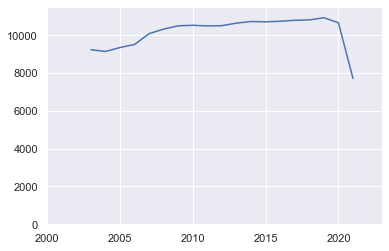

In [28]:
years = np.array([0])
games = np.array([0])
for i in range(2003, 2023):
    games = np.append(games, np.shape(data.loc[(data.Season == i)])[0])
    years = np.append(years, i)
    
plt.plot(years[1:-1], games[1:-1])
plt.axis([2000, 2023, 0, 11500])
plt.show()

By looking up a specific team, and its record on other sites, we are able to see that the data table is incomplete. By counting the total number of games per year, though, we see that this seems to be limited to 2022 and 2021. This makes sense for 2022 considering the need for training data to be available prior to the start of the March Madness tournament, but the same can't be said for 2021.

## Basic metric correlations

Let's take a moment to see what the cross-correlations between the different metrics are prior to any engineering -- we're most interested in the correlation to winning, but it's good to see how they all relate to each other.

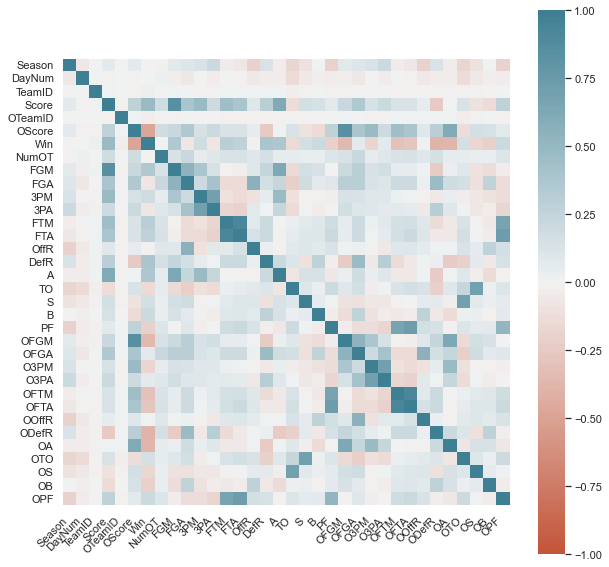

In [29]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

corr = data.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We certainly see some strong correlation between different metrics, but none that particularly surprise us. It makes sense for free throws, field goals, and 3-pointers made to correlate strongly to score, as well as for personal fouls to correlate to the opposing teams free throws made and attempted. "Win" does have some strong correlations that, again, make sense: an opponents score correlates negatively, while made 3-pointers correlates positively. It is interesting to note, however, that the attempt does not have a strong correlation.

## Let's get on with feature engineering

It's time for us to get back on track after that little aside. Let's refresh our memory of what we're aiming to do: (2) we will iterate through the team dataframe, creating columns for each seasonal and sub-seasonal metric. Then, (3) we will iterate through the main dataframe again, filling in the seasonal and sub-seasonal metrics and calculating specific game performance relative to them. Lastly, (4) we will iterate through a third time and calculate each team's impact on opponents for each game, seasonally, and sub-seasonally.

## At some point let's add in the average end-of-season rank of TeamID and OTeamID